## Topic Modelling

Topic Modelling and NER to analyze the evolving topics of disccusion around Ozempic on related subreddits

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from nltk.corpus import stopwords

/home/joflesan/miniconda3/envs/dssip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the parquet files
df = pd.read_parquet("../data/reddit/loseit_topall_searchOzempic.parquet")
df_sorted = df.sort_values(by="timestamp", ascending=True)
df_sorted.head()

,title,content,distinguished,upvotes,upvote_ratio,timestamp,comments
82,"Ozempic, do you gain it all back?","M, 5’9, 245 lbs, 22\n\n\nI have an upcoming ap...",False,8,0.90,1.612324e+09,[{'content': 'I took it for a year or so. Whe...
43,Eating Once a Day due to Vyvanse & Ozempic,This is not something I EVER thought I would b...,False,34,0.97,1.619132e+09,[{'content': 'I have worried over the same thi...
69,Ozempic / Wegovey,Apparently the FDA has approved a semaglutide ...,False,8,0.75,1.624623e+09,[{'content': 'Hi there! Perhaps a medical prof...
79,"Finally, feel like I'm on track (using Ozempic)",I have struggled with my weight since I was 19...,False,16,0.90,1.644975e+09,[{'content': 'I'm taking phentermine. I love n...
2,"Is this how ""normal people"" feel after eating?...",So my doctor prescribed me Ozempic a week ago....,False,2186,0.97,1.648315e+09,"[{'content': 'Thank you for writing this, it’s..."


In [4]:
# Flatten the dataframe
def flatten(df: pd.DataFrame):
    flattened_rows = []

    for idx, row in df.iterrows():
        flattened_rows.append({
            "type": "post",
            "post_index": idx,
            "content": f"{row['title']}. {row['content']}",
            "upvotes": row['upvotes'],
            "timestamp": row['timestamp']
        })

        # Add each comment as its own row
        for comment in row.get("comments", []):
            flattened_rows.append({
                "type": "comment",
                "post_index": idx,
                "content": comment['content'],
                "upvotes": comment["upvotes"],
                "timestamp": comment['timestamp']
            })

    return pd.DataFrame(flattened_rows)

flat_df = flatten(df)
flat_df.head()

,type,post_index,content,upvotes,timestamp
0,post,0,Honest Ozempic reviews. Does it really work or...,556,1.704485e+09
1,comment,0,"OP, you have received sufficient anecdotal inf...",1,1.704503e+09
2,comment,0,"Semaglutide, Ozempic, is a GLP-1 agonist drug....",134,1.704494e+09
3,comment,0,"I didn’t take Ozempic, but I did take Mounjaro...",330,1.704491e+09
4,comment,0,"I'm on wegovy, but same diff. It's entirely tr...",591,1.704490e+09


In [5]:
flat_df["year"] = pd.to_datetime(flat_df["timestamp"], unit="s").dt.year
yearly_counts = flat_df["year"].value_counts().sort_index()
print(yearly_counts)

year
2021      38
2022     568
2023    2812
2024    2500
2025     888
Name: count, dtype: int64


Basic Topic Modelling using BERTopic

In [6]:
documents = flat_df["content"].fillna("")

In [17]:
nltk.download("stopwords")
stop_words = stopwords.words("english")

# Initialize CountVectorizer with stopwords
vectorizer_model = CountVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 3)    
)

# Instantiate and fit the model
model = BERTopic(vectorizer_model=vectorizer_model, calculate_probabilities=True)
topics, probs = model.fit_transform(documents)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joflesan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
flat_df["topics"] = topics

In [19]:
flat_df["topic_probs"] = probs

In [12]:
fig = model.visualize_topics()
fig.show()

In [13]:
model.visualize_hierarchy()

In [14]:
model.visualize_barchart()

In [21]:
model.visualize_documents(documents, topics=model.topics_[:100], embeddings=None)

In [20]:
# Most popular topics overall
topic_info = model.get_topic_info()
print(topic_info.head(15))

    Topic  Count                                               Name  \
0      -1   2757                              -1_weight_im_eat_food   
1       0    322                         0_ozempic_weight_people_im   
2       1    277                           1_people_say_weight_tell   
3       2    234                      2_weight_calories_lose_pounds   
4       3    143                 3_drug_effects_side effects_weight   
5       4    136                        4_calories_tdee_deficit_day   
6       5    121                   5_noise_food noise_food_thoughts   
7       6    121                  6_calories_tracking_calorie_track   
8       7    113               7_thyroid_pcos_hypothyroidism_weight   
9       8    110        8_congratulations_proud_incredible_congrats   
10      9     93                           9_hunger_hungry_eat_full   
11     10     90                   10_binge_binge eating_eating_eat   
12     11     80           11_congratulations_weight_thank_congrats   
13    

In [21]:
# Find most important topics by year
topicByYear = flat_df.groupby(["year", "topics"]).size().reset_index(name="count")
topicByYear = topicByYear[topicByYear["topics"] != -1]  # Filter out outliers

In [22]:
# Get keywords and add to DF
def get_keywords(topicId):
    return ", ".join([word for word, _ in model.get_topic(topicId)])

# Find top N topics per year
topN = 10
topTopicsPerYear = topicByYear.groupby("year").apply(
    lambda x: x.sort_values(by="count", ascending=False).head(topN)
).reset_index(drop=True)

print(topTopicsPerYear)

    year  topics  count
0   2021       0      6
1   2021       3      6
2   2021       9      2
3   2021      11      2
4   2021      22      1
5   2021      37      1
6   2021      41      1
7   2021      45      1
8   2021      51      1
9   2021      59      1
10  2022       0     33
11  2022      13     31
12  2022      33     31
13  2022      50     26
14  2022      20     20
15  2022       8     17
16  2022       9     16
17  2022      77     13
18  2022      11     13
19  2022      70     12
20  2023       0    213
21  2023       1     95
22  2023       3     89
23  2023       2     87
24  2023       5     55
25  2023      19     49
26  2023      21     46
27  2023      25     44
28  2023       8     44
29  2023       4     36
30  2024       1    132
31  2024       2     86
32  2024       7     70
33  2024       0     61
34  2024       4     61
35  2024      10     55
36  2024       6     54
37  2024      15     45
38  2024      23     43
39  2024       5     42
40  2025       2

/tmp/ipykernel_1276929/1469121983.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topTopicsPerYear = topicByYear.groupby("year").apply(


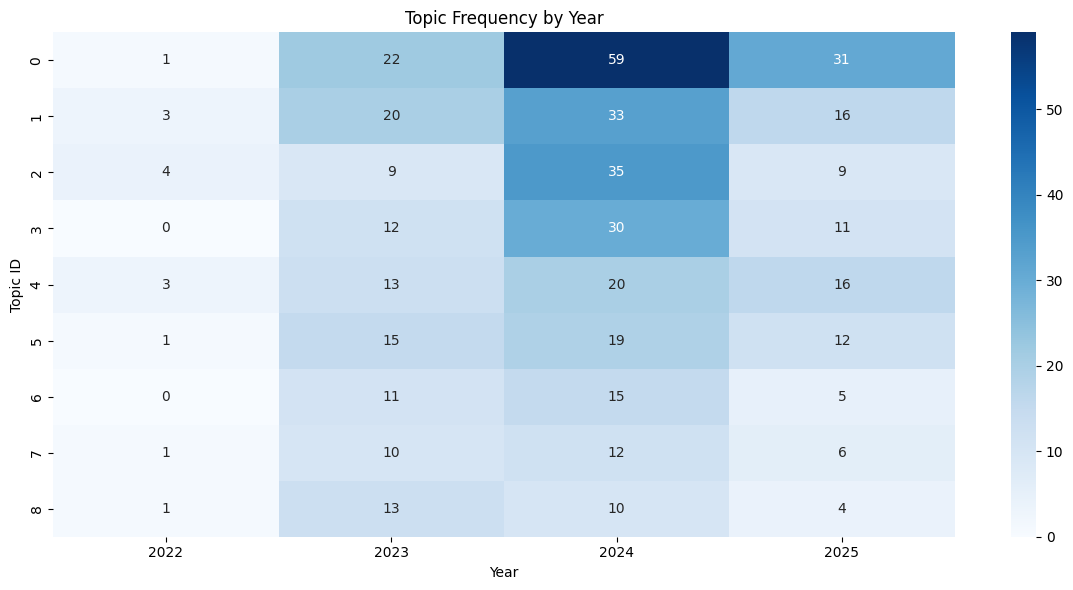

In [52]:
# Pivot to wide format for heatmap
heatmapData = topicByYear.pivot(index="topics", columns="year", values="count").fillna(0)

# Only plot top N overall topics
topTopicIds = df["topics"].value_counts().head(10).index[1:]
heatmapData = heatmapData.loc[topTopicIds]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmapData, cmap="Blues", annot=True, fmt="g")
plt.title("Topic Frequency by Year")
plt.ylabel("Topic ID")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

In [24]:
topicsOverTime = model.topics_over_time(documents, flat_df["timestamp"].tolist(), global_tuning=True)

# Filter topics that contain mental health terms
topicInfo = model.get_topic_info()
mh_topics = topicInfo[topicInfo["Name"].str.contains("anxious|depress|panic|binge|fast", case=False)]

2025-04-22 13:33:35,017 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 6803) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


In [14]:
model.get_topic_info().iloc[:10]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2824,-1_weight_im_eat_food,"[weight, im, eat, food, like, eating, dont, da...",[Soda addiction - is it possible to work aroun...
1,0,320,0_ozempic_weight_people_insulin,"[ozempic, weight, people, insulin, im, effects...",[This is incorrect. Ozempic lowers blood sugar...
2,1,310,1_people_say_tell_weight,"[people, say, tell, weight, like, dont, commen...",[I think it's really a matter of personal opin...
3,2,218,2_calories_weight_pounds_lose,"[calories, weight, pounds, lose, week, day, do...",[I sincerely hope you hit your goal and have a...
4,3,145,3_calories_tdee_deficit_day,"[calories, tdee, deficit, day, weight, 1200, 1...","[TDEE?, 2000 calories a day and obese?. I’ve (..."
5,4,136,4_effects_side effects_drug_weight,"[effects, side effects, drug, weight, side, ta...","[First off, it is absolutely appropriate to ta..."
6,5,129,5_noise_food noise_food_thoughts,"[noise, food noise, food, thoughts, eat, im, l...","[How to get rid of ""food noise"" without medica..."
7,6,129,6_calories_tracking_calorie_counting,"[calories, tracking, calorie, counting, track,...","[Honestly, I'm just gonna say you have to push..."
8,7,109,7_thyroid_pcos_hypothyroidism_weight,"[thyroid, pcos, hypothyroidism, weight, lose, ...",[You literally said you had adrenal gland prob...
9,8,96,8_congratulations_proud_congrats_incredible,"[congratulations, proud, congrats, incredible,...","[Congratulations!!!, Congratulations, Congratu..."


In [25]:
mh_topics

,Topic,Count,Name,Representation,Representative_Docs
11,10,90,10_binge_binge eating_eating_eat,"[binge, binge eating, eating, eat, binging, fo...",[Has anyone actually beaten binge eating? I ha...
13,12,64,12_fasting_intermittent_intermittent fasting_w...,"[fasting, intermittent, intermittent fasting, ...","[Intermittent fasting - OMAD to 20/4, Try inte..."
29,28,42,28_therapy_depression_therapist_help,"[therapy, depression, therapist, help, medicat...",[cognitive behavioral therapy- talk therapy d...
48,47,27,47_depression_health_mental_youre,"[depression, health, mental, youre, mental hea...",[You need to make an appointment with your doc...
63,62,19,62_breakfast_lunch_hours_eat,"[breakfast, lunch, hours, eat, pm, hours witho...",[How much do you eat for breakfast and lunch?\...


In [26]:
representative = model.get_representative_docs(0)
for i, doc in enumerate(representative[:5]):
    print(f"\n--- Document {i + 1} ---\n{doc}")


--- Document 1 ---
Sharing my real experience with Ozempic I caught the post yesterday about 'people lying about Ozempic' and was too late to the party to share my experience.

I worked with my doctor last summer and was prescribed Ozempic for weight loss.  At the time, I was 38 yrs old, 6' 2", and 365lbs and am Male.  At the time, I had just done my annual checkup and all of my blood work was normal - no high A1C, no high cholesterol, sodium, etc etc.

As a bit of back story to this - In the past, I pretty much would just eat until the food in front of me was gone.  That's what I was taught growing up - eat until your plate is clean.  It's a habit I've struggled with and have yet to overcome.  I don't really know the difference between "hungry" and "not full."  For me it's basically "I'm hungry" and then "holy shit I'm so fucking stuffed I could pop."

So last summer, my doc started me on Ozempic at 0.25mg weekly dosage.  I was at this dose for about 3 months and then increased to 0.